# **Телеком**



Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Нужно:

1. Подготовить данные
2. Провести исследовательский анализ данных
3. Подготовить данные для ML
4. Построить и обучить модель
5. Проверить модель на адекватность и соответствию метрики AUC-ROC > 0.85
6. Написать общий вывод и сверится с планом работы

## **Загрузка и ознокомление с данными**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import (classification_report, accuracy_score, roc_auc_score,
                             confusion_matrix, plot_confusion_matrix
                            )
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier

In [ ]:
try:
    contract_new = pd.read_csv('***')
    personal_new = pd.read_csv('***')
    internet_new = pd.read_csv('***')
    phone_new = pd.read_csv('***')
except:
    contract_new = pd.read_csv('https://***')
    personal_new = pd.read_csv('https://***')
    internet_new = pd.read_csv('https://***')
    phone_new = pd.read_csv('https://***')

In [ ]:
def view_information(data):
    print('Размер датасета:', data.shape)
    display(data.head())
    print(data.info())
    print('Пропуски:', data.isna().sum())
    print()
    print('Количество дубликатов', data.duplicated().sum())
    display(data.describe())


**Смотрим датафрейм contract_new (информация о договоре).**



In [ ]:
view_information(contract_new)

Размер датасета: (7043, 8)


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None
Пропуски: customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Количество дубликатов 0


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


Посмотрим как распределены ежемесячные траты на услуги

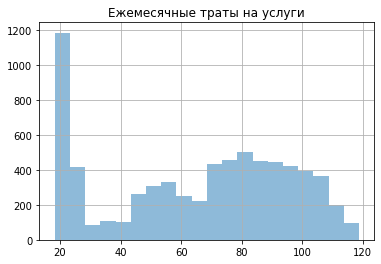

In [ ]:
contract_new['MonthlyCharges'].hist(bins=20, alpha=0.5)
plt.title('Ежемесячные траты на услуги')
plt.show()

In [ ]:
contract_new['TotalCharges'] = contract_new['TotalCharges'].replace(' ', 0).astype('float64')
print(contract_new['TotalCharges'].dtype)

float64


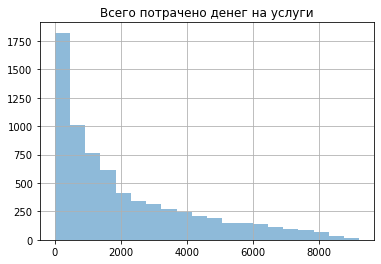

In [ ]:
contract_new['TotalCharges'].hist(bins=20, alpha=0.5)
plt.title('Всего потрачено денег на услуги')
plt.show()

Промежуточный вывод о contract_new:

*   Размер датасета: (7043, 8);
*   dtypes: float64(1), object(7). Тип данных Float64 имеет признак MonthlyCharges
*   Нет пропусков
*   Нет дубликатов
*   Пик ежемесячной платы за услуги в районе минимальной оплаты в 20 (Наверное долларов), большинство клиентов имеют низкую ежемесячную плату за услуги
* На гистограмме "Всего потрачено денег на услуги" мы видим что больше всего потрачено до 500 (наверное долларов) зв всё время пользования услугами/услугой абонентами.





**Смотрим датафрейм personal_new (Персональные данные о клиенте).**

In [ ]:
view_information(personal_new)

Размер датасета: (7043, 5)


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None
Пропуски: customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

Количество дубликатов 0


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Промежуточный вывод о personal_new:

*   Размер датасета: (7043, 5);
*   dtypes: int64(1), object(4). Тип данных int64 имеет признак SeniorCitizen что подразумевает наличие пенсионного статуса клиента. Этот признак посути содержит в себе булево значение.
*   Нет пропусков
*   Нет дубликатов



**Смотрим датафрейм internet_new (Информация об интернет услугах).**

In [ ]:
view_information(internet_new)

Размер датасета: (5517, 8)


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None
Пропуски: customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

Количество дубликатов 0


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,9705-IOVQQ,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Промежуточный вывод о internet_new:

*   Размер датасета: (5517, 8) Количество строк нам говорит о том что не все клиенты Ниединогоразрыва.ком пользуются интернетом;
*   dtypes: object(8). Все признаки кроме идентификатора абонента имеют булевы значения
*   Нет пропусков
*   Нет дубликатов



**Смотрим датафрейм phone_new (Информация об услугах телефонии).**

In [ ]:
view_information(phone_new)

Размер датасета: (6361, 2)


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None
Пропуски: customerID       0
MultipleLines    0
dtype: int64

Количество дубликатов 0


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,9705-IOVQQ,No
freq,1,3390


Промежуточный вывод о internet_new:

*   Размер датасета: (6361, 2) Количество строк нам говорит о том что не все клиенты Ниединогоразрыва.ком пользуются услугами телефонии;
*   dtypes: object(2)
*   Нет пропусков
*   Нет дубликатов

**Общий вывод о датасетах**:
* Мы имеем 4 датасета содержащих в себе :
  1. Информацию о договоре;
  2. Персональные данные о клиентах Ниединогоразрыва.ком
  3. Информация об интернет-услугах
  4. Информацию об услугах телефонии
* У нас есть информация о 7042 клиентах компании. Из них 6361 пользуется телефонией и 5517 пользуется интернетом.
* Наши датасеты не имеют дубликатов и пропусков.
* customerID во всех датасетах является идентификатором абонента, что даёт нам возможность установить данный столбец как индекс.
* У большей части абонентов низкие траты на услуги.

## Анализ данных и подготовка признаков

Объеденим таблицы по столбцу customerID, являющемся идентифекатором абонента и установим этот столбец как индекс.

In [ ]:
df = contract_new.merge(personal_new, on='customerID', how='outer')
df = df.merge(internet_new, on='customerID', how='outer')
df = df.merge(phone_new, on='customerID', how='outer')

In [ ]:
df.set_index('customerID', inplace=True)

In [ ]:
view_information(df)

Размер датасета: (7043, 19)


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   float64
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   5517 non-null   object 
 12  OnlineSecurity    5517 non-null   object 
 13  OnlineBackup      5517 non-null   object 
 14  DeviceProtection  5517 non-null   object 
 15  TechSupport       5517 non-null   object 
 16  StreamingTV       5517 non-null 

,MonthlyCharges,TotalCharges,SeniorCitizen
count,7043.000000,7043.000000,7043.000000
mean,64.761692,2115.312885,0.162147
std,30.090047,2112.742814,0.368612
min,18.250000,0.000000,0.000000
25%,35.500000,436.750000,0.000000
50%,70.350000,1343.350000,0.000000
75%,89.850000,3236.690000,0.000000
max,118.750000,9221.380000,1.000000


Что мы видим после объеденения таблиц:
* Размер датасета: (7043, 19) Все столбцы и строки на месте
* Типы данных в столбцах: 2 столбца типа float64, 1 столбец типа int64, 16 столбцов типа object
* Столбцы InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies имеют 1526 пропущенных значений
* Столбец MultipleLines имеет 682 пропущенных значений
* Количество дубликатов в данных составляет 4



Начнём с обработки пропущенных значений: Столбцы InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, MultipleLines  содержат пропущенные значения. Основываясь на те данные что мы получили когда смотрели датасеты по отдельности, мы можем сделать вывод, что пропуски значат отсутствие услуги у клиента и можем смело заменить их на 'No'

In [ ]:
columns = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']
df[columns] = df[columns].fillna('No')
print(df.isna().sum())

BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64


Преобразуем тип данных в столбце SeniorCitizen на object

In [ ]:
df['SeniorCitizen'] = df['SeniorCitizen'].astype('object')
print(df['SeniorCitizen'].dtype)

object


In [ ]:
duplicates = df.loc[df.duplicated()]
display(duplicates)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
8605-ITULD,2020-01-01,No,Month-to-month,No,Mailed check,19.55,19.55,Female,0,No,No,No,No,No,No,No,No,No,No
2668-TZSPS,2020-01-01,No,Month-to-month,No,Mailed check,20.45,20.45,Male,0,No,No,No,No,No,No,No,No,No,No
3892-NXAZG,2014-02-01,No,Two year,Yes,Credit card (automatic),114.05,8211.60,Male,0,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
8774-GSBUN,2014-02-01,No,Two year,No,Mailed check,25.40,1828.80,Male,0,Yes,No,No,No,No,No,No,No,No,Yes


In [ ]:
index_counts = df.index.value_counts()
duplicates = index_counts[index_counts > 1]
print(duplicates)

Series([], Name: customerID, dtype: int64)


Наши 'дубликаты' не являются дубликатами, т.к. при проверки не был учтён индекс представляющий собой идентификатор абонента

Создадим целевой признак, где 0 означает что клиент всё ещё пользуется услугами и 1 - что человек больше не пользуется услугами.

In [ ]:
df['Churn'] = df['EndDate'].apply(lambda x: 0 if x == 'No' else 1)

Создадим ещё один новый признак, который содержит в себе количество дней пользования услугами компании. Далее отсортируем дату начала пользования и дату окончания пользования услугами из нашего датасета.

In [ ]:
df['EndDate'] = df['EndDate'].replace('No', '2020-02-01')
last_date = df['EndDate'].max()

In [ ]:
print(last_date)

2020-02-01


In [ ]:
df['BeginDate'] = pd.to_datetime(df['BeginDate'])
df['EndDate'] = pd.to_datetime(df['EndDate'])

df['DaysUsed'] = (df['EndDate'] - df['BeginDate']).dt.days

In [ ]:
df = df.drop(['BeginDate', 'EndDate'], axis=1)
display(df.head(1))

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Churn,DaysUsed
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,0,31


Теперь посмотрим корреляцию между признаками
1. Напишем функцию которая вычисляет коэффициент корреляции Крамера между двумя категориальными признаками.
2. Создадим матрицу, в которой каждый элемент представляет собой коэффициент Крамера между соответствующими категориальными признаками
3. Отобразим матрицу в виде тепловой карты

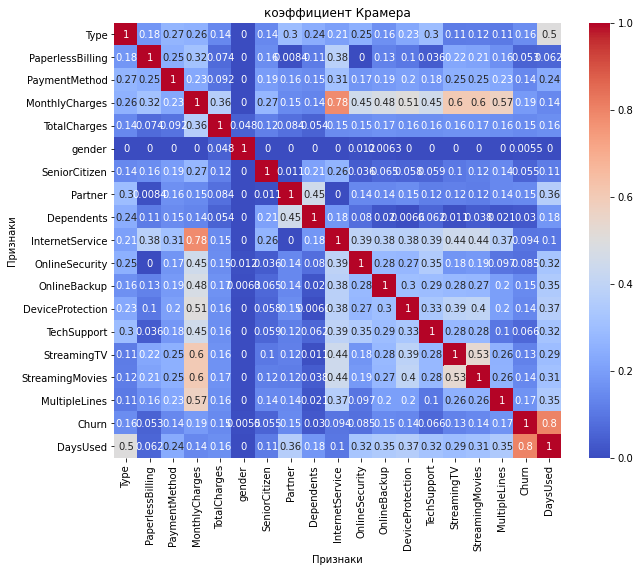

In [ ]:
cols = ['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
            'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
            'OnlineSecurity', 'OnlineBackup', 'DeviceProtection','TechSupport',
            'StreamingTV', 'StreamingMovies', 'MultipleLines', 'Churn', 'DaysUsed']

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

corr_matrix = np.zeros((len(cols), len(cols)))
for i in range(len(cols)):
    for j in range(len(cols)):
        corr_matrix[i, j] = cramers_v(df[cols[i]], df[cols[j]])

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', xticklabels=cols, yticklabels=cols)
plt.xlabel('Признаки')
plt.ylabel('Признаки')
plt.title('коэффициент Крамера')
plt.show()

На тепловой карте есть признаки с положительной корреляцией и с отсутствием таковой. Дни имеют сильную положительную корреляцию с целевым признаком.

Напишем функцию которая будет принимать на вход наш датафрейм, имена признаков, целевой признак и строить графики для каждого признака вместе с целевым признаком

In [ ]:
cat_cols = ['Type', 'PaperlessBilling', 'PaymentMethod',
            'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
            'OnlineSecurity', 'OnlineBackup', 'DeviceProtection','TechSupport',
            'StreamingTV', 'StreamingMovies', 'MultipleLines', 'Churn']

def plot_features(df, cat_cols, target_col):
    for col in cat_cols:
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, x=col, hue=target_col)
        plt.title(f'{col} vs {target_col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.legend(title=target_col)
        plt.show()

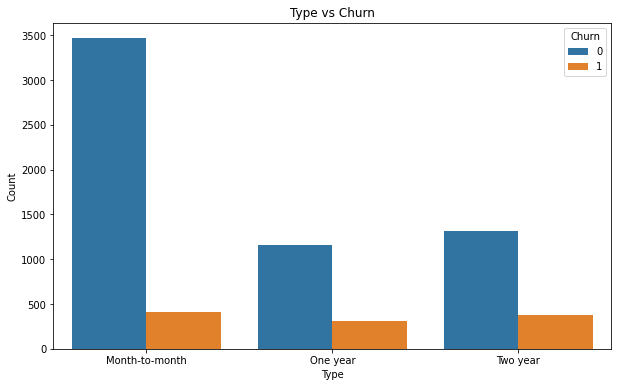

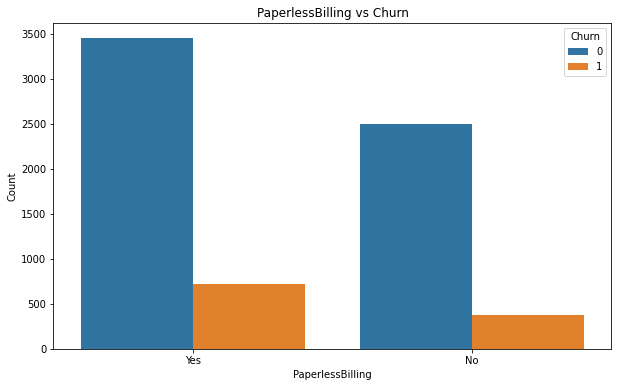

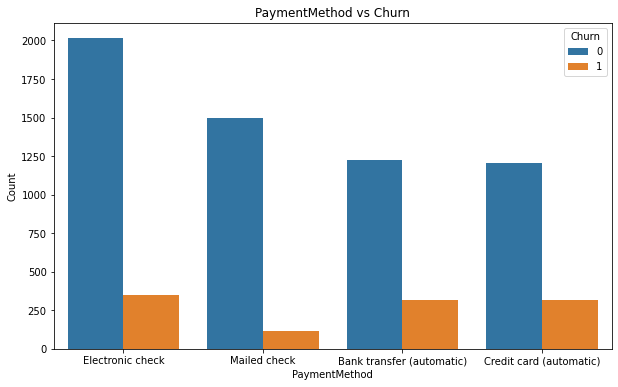

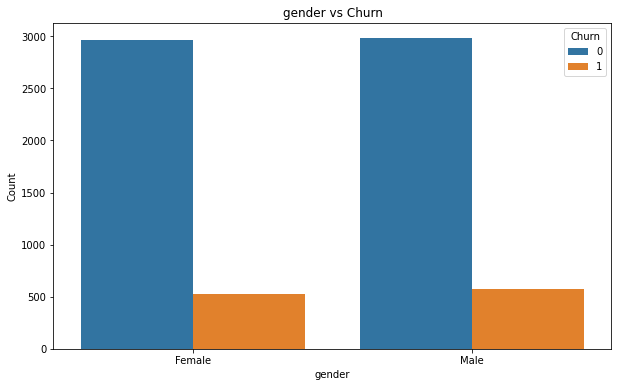

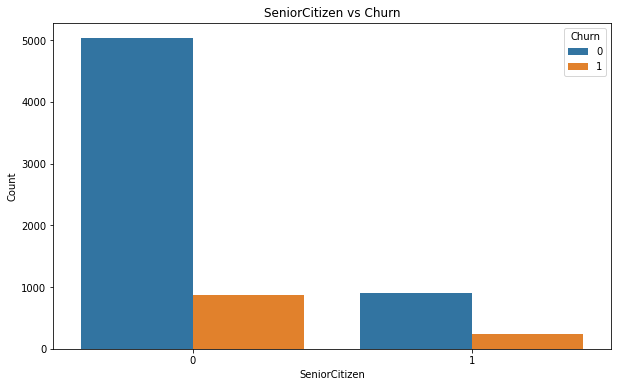

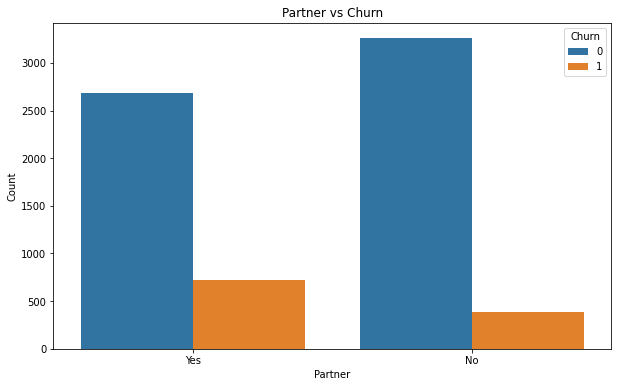

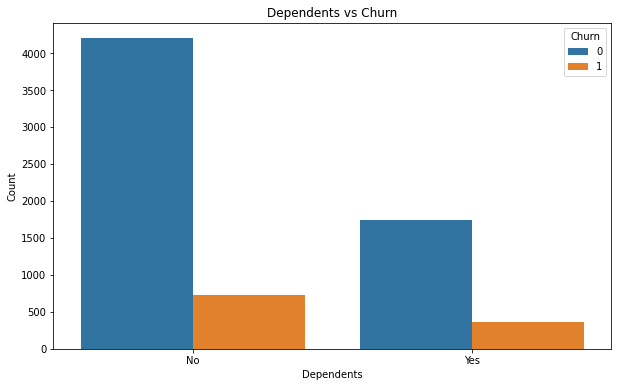

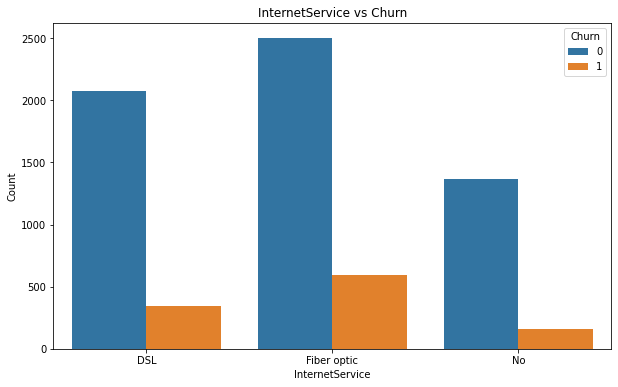

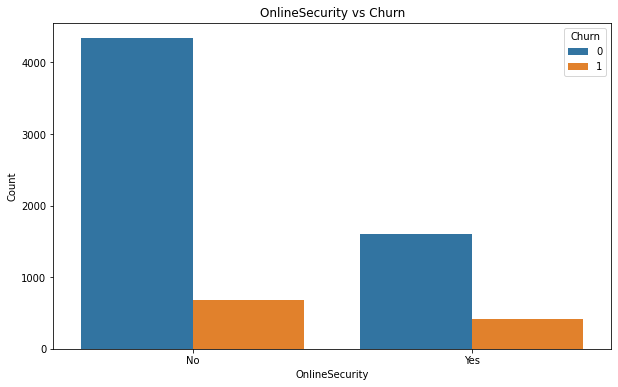

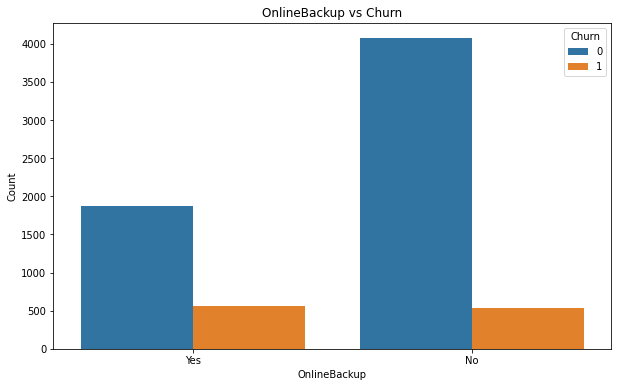

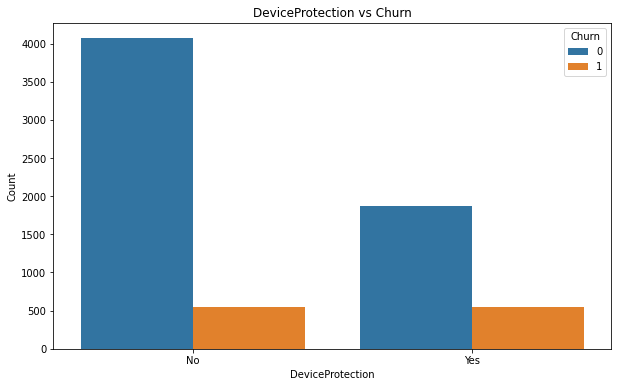

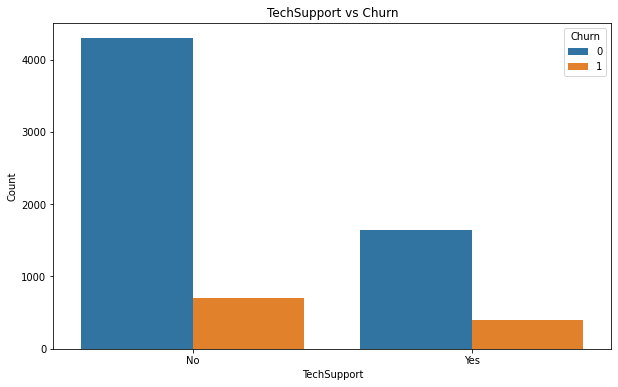

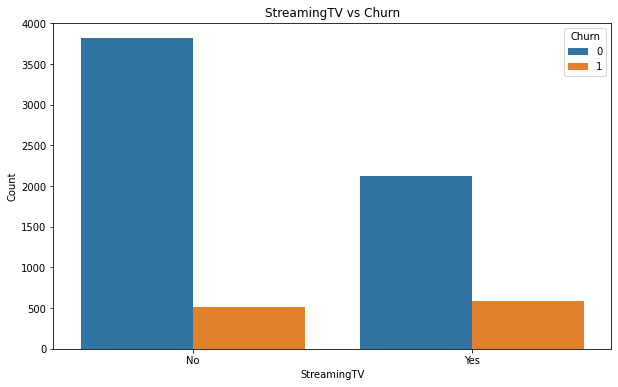

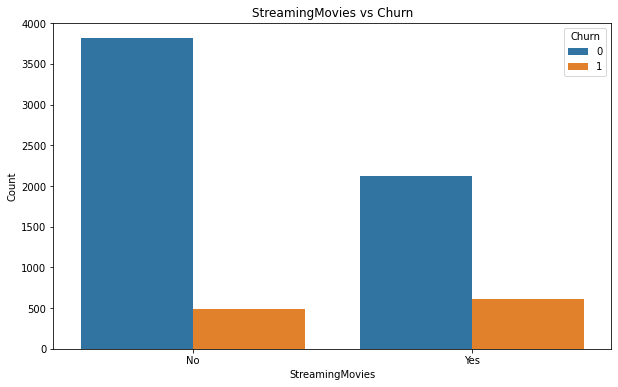

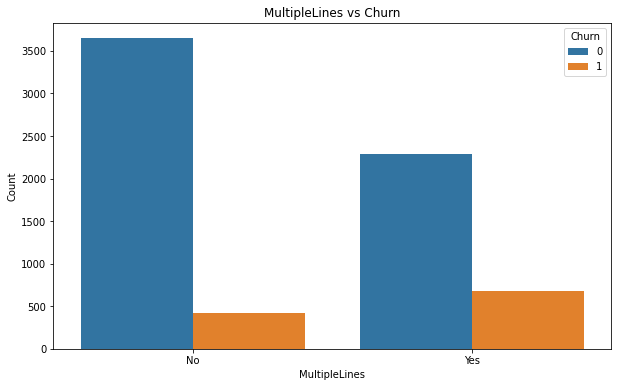

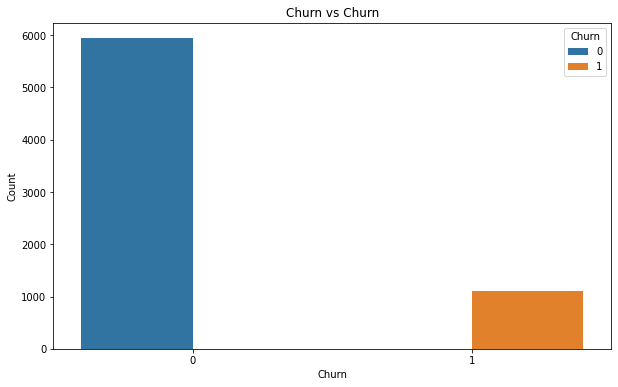

In [ ]:
plot_features(df, cat_cols, 'Churn')

* Больше всего отказываются от услуг клиенты которые платят раз в год или в два года, чем те кто платит месяц в месяц.
* Меньше всего отказываются от услуг клиенты которые пользуется способом оплаты Mailed check
* Пол совершенно не влияет на отток
* Те кто не имеет партёра меньше отказываются от услуг оператора
* Те кто не имеет техподдержку уходят в 2 раза чаще, чем те кто имеет

Посмотрим более подробно числовые признаки по отношению к таргету


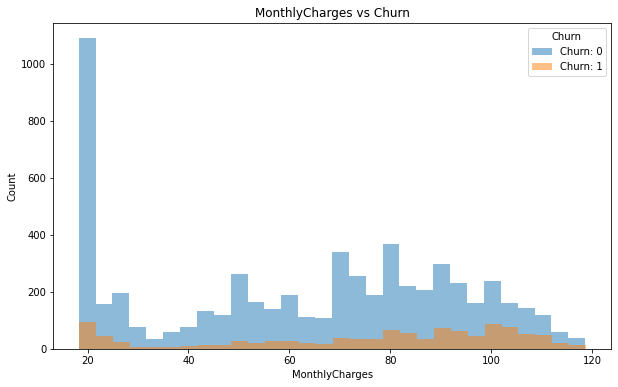

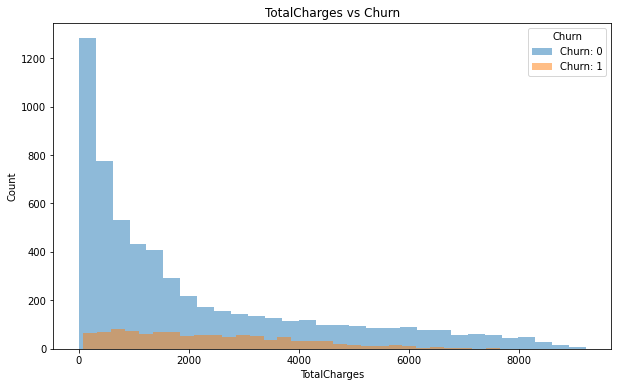

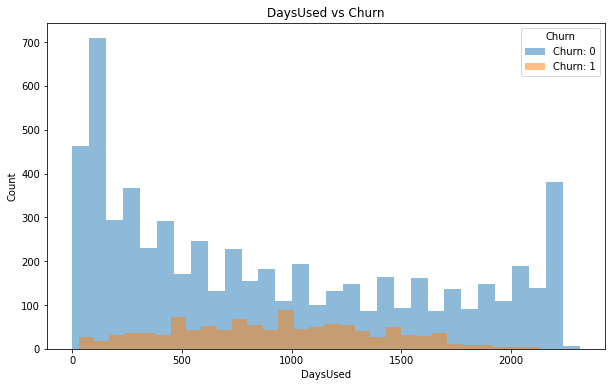

In [ ]:
num_cols = ['MonthlyCharges', 'TotalCharges', 'DaysUsed']

def plot_numerical_features(df, cols, target_col):
    churn_0 = df[df[target_col] == 0]
    churn_1 = df[df[target_col] == 1]

    for col in cols:
        plt.figure(figsize=(10, 6))
        plt.hist(churn_0[col], alpha=0.5, label='Churn: 0', bins=30)
        plt.hist(churn_1[col], alpha=0.5, label='Churn: 1', bins=30)
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.legend(title=target_col)
        plt.title(f'{col} vs {target_col}')
        plt.show()


plot_numerical_features(df, num_cols, 'Churn')

* Клиенты уходят как и с низким, так и высоким ежемесячным платежём. Возможно кто-то отказывается от услуг телефонии, а для кого-то ежемесячный платёж слишком высок, в то время как со средним платежём люди уходят значительно меньше.
* Если посмотреть на платежи за всё время пользование услугами, то чаще уходят те у кого платёж не привысил 5000 у.е. те у кого общая сумма выше уходят реже. Возможно сказывается время пользования услугами.
* С продолжительностью пользования услугами мы видим что те клиенты кто пользуются услугами давно, гораздо реже отказываются от услуг оператора.

### Проверка на дисбаланс классов

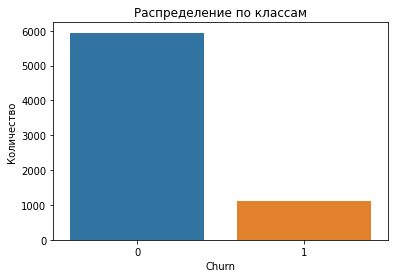

In [ ]:
sns.countplot(x='Churn', data=df)
plt.xlabel('Churn')
plt.ylabel('Количество')
plt.title('Распределение по классам')
plt.show()

На графике видно что существует большой дисбаланс классов в сторону клиентов которые остались в компании, в данном случае я буду применять три модели XGBoost, LightGBM, CatBoost, которые имеют встроенную поддержку для обработки дисбаланса.

Т.к. мы будем использовать эти три модели, проверим типы данных

In [ ]:
print(df.dtypes)

Type                 object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
gender               object
SeniorCitizen        object
Partner              object
Dependents           object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
MultipleLines        object
Churn                 int64
DaysUsed              int64
dtype: object


MonthlyCharges и TotalCharges имеют тип данных float64, проведём масштабирование признаков в случае с DaysUsed имеющим тип данных int64 поступим так-же.

## Подготовка данных и построение модели

In [ ]:
RANDOM_STATE = 220523

Разобьём данные на выборки

In [ ]:
X = df.drop('Churn', axis=1)
y = df['Churn']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
print('Тренировочная выборка:', x_train.shape, end='')
print()
print('Таргет тренировочной выборки:', y_train.shape, end='')
print()
print('Тестовая выборка:', x_test.shape, end='')
print()
print('Таргет тестовой выборки:', y_test.shape, end='')

Тренировочная выборка: (5282, 18)
Таргет тренировочной выборки: (5282,)
Тестовая выборка: (1761, 18)
Таргет тестовой выборки: (1761,)

In [ ]:
#num_cols = ['MonthlyCharges', 'TotalCharges', 'DaysUsed']
#scaler = StandardScaler()
#pd.options.mode.chained_assignment = None
#x_train.loc[:, num_cols] = scaler.fit_transform(x_train[num_cols])
#x_test.loc[:, num_cols] = scaler.transform(x_test[num_cols])

In [ ]:
display(x_train.head(3), x_train.isna().sum())

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,DaysUsed
customerID,,,,,,,,,,,,,,,,,,
2205-LPVGL,One year,Yes,Bank transfer (automatic),89.85,5211.30,Male,1,Yes,Yes,Fiber optic,Yes,Yes,No,Yes,No,No,Yes,1767
5940-NFXKV,Month-to-month,Yes,Electronic check,83.65,271.03,Male,0,Yes,Yes,Fiber optic,No,No,No,No,No,Yes,Yes,92
5453-YBTWV,Two year,Yes,Credit card (automatic),101.10,7643.16,Male,0,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,No,No,2132


Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
DaysUsed            0
dtype: int64

## Модели

In [ ]:
print(df.dtypes)

Type                 object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
gender               object
SeniorCitizen        object
Partner              object
Dependents           object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
MultipleLines        object
Churn                 int64
DaysUsed              int64
dtype: object


In [ ]:
num_cols = ['MonthlyCharges', 'TotalCharges', 'DaysUsed']
cat_cols = ['Type', 'PaperlessBilling', 'PaymentMethod','gender', 'SeniorCitizen',
            'Partner', 'Dependents', 'InternetService','OnlineSecurity',
            'OnlineBackup', 'DeviceProtection','TechSupport',
            'StreamingTV', 'StreamingMovies', 'MultipleLines']

categorical_transformer = OneHotEncoder(handle_unknown='error',  drop='first')
numeric_transformer = StandardScaler()

**LightGBM**

In [ ]:
pipeline_lgbm = Pipeline([
    ('preprocessing', ColumnTransformer([
        ('categorical', categorical_transformer, cat_cols),
        #('numeric', numeric_transformer, num_cols)
    ])),
    ('lgbm', lgb.LGBMClassifier(random_state=RANDOM_STATE))
])

parameters_lgbm = {
    'lgbm__n_estimators': [100, 200],
    'lgbm__max_depth': [3, 4, 5],
    'lgbm__learning_rate': [0.1, 0.01],
#     'lgbm__num_threads':[1] #Код ревьюера
}

In [ ]:
grid_search_lgbm = GridSearchCV(pipeline_lgbm, parameters_lgbm, scoring='roc_auc', cv=3, n_jobs=-1)
grid_search_lgbm.fit(x_train, y_train)
best_model_lgbm = grid_search_lgbm.best_estimator_
best_params_lgbm = grid_search_lgbm.best_params_
print("Лучшая метрика AUC-ROC:", grid_search_lgbm.best_score_)

Лучшая метрика AUC-ROC: 0.6999865513549869


**CatBoost**

In [ ]:
pipeline_catboost = Pipeline([
    ('catboost', CatBoostClassifier(cat_features=cat_cols))
])

parameters_catboost = {
    'catboost__iterations': [100, 200],
    'catboost__max_depth': [3, 4, 5],
    'catboost__learning_rate': [0.1, 0.01]
}

In [ ]:
grid_search_catboost = GridSearchCV(pipeline_catboost, parameters_catboost, scoring='roc_auc', refit=True,
    cv=KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    n_jobs=-1)
grid_search_catboost.fit(x_train, y_train)
best_model_catboost = grid_search_catboost.best_estimator_
best_params_catboost = grid_search_catboost.best_params_
print("Лучшая метрика AUC-ROC:", grid_search_catboost.best_score_)


* Лучшая метрика AUC-ROC модели LightGBM на тестовой выборке: 0.70
* Лучшая метрика AUC-ROC модели CatBoost: 0.86

Посмотрим acuracy этих моделях.

In [ ]:
y_pred_lgbm = best_model_lgbm.predict(x_train)
y_pred_catboost = best_model_catboost.predict(x_train)

accuracy_lgbm = accuracy_score(y_train, y_pred_lgbm)
accuracy_catboost = accuracy_score(y_train, y_pred_catboost)

print("Точность модели LightGBM: {:.4f}".format(accuracy_lgbm))
print("Точность модели CatBoost: {:.4f}".format(accuracy_catboost))

Точность модели LightGBM: 0.8398
Точность модели CatBoost: 0.9036


* Точность модели LightGBM: 0.8398
* Точность модели CatBoost: 0.9036

Модель CatBoost демонстрирует самую высокую точность среди трех моделей, равную 0.9057

**Проведём анализ моделей**

In [ ]:
best_score_lgbm = grid_search_lgbm.best_score_
best_score_catboost = grid_search_catboost.best_score_

In [ ]:
df_model = [
    {
        'Модель': 'LightGBM',
        'AUC-ROC': best_score_lgbm,
        'accuracy': accuracy_lgbm
    },
    {
        'Модель': 'CatBoost',
        'AUC-ROC': best_score_catboost,
        'accuracy': accuracy_catboost
    }
]

data_model = pd.DataFrame(df_model)
display(data_model)

,Модель,AUC-ROC,accuracy
0,LightGBM,0.699987,0.839833
1,CatBoost,0.867927,0.903635


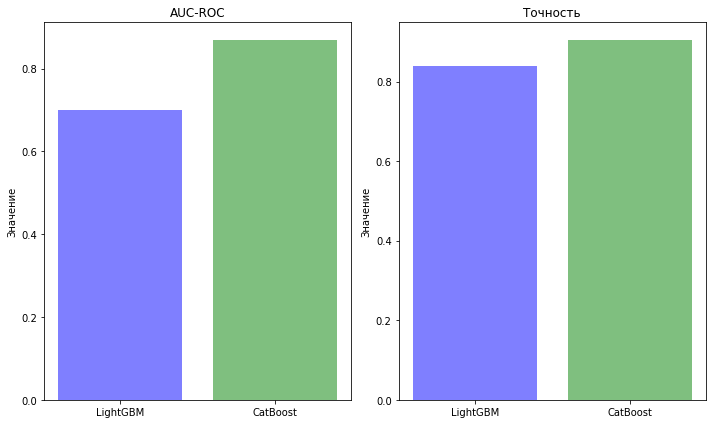

In [ ]:
models = data_model['Модель']
auc_roc = data_model['AUC-ROC']
accuracy = data_model['accuracy']

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.bar(models, auc_roc, alpha=0.5, color=['blue', 'green', 'red'])
plt.title('AUC-ROC')
plt.ylabel('Значение')

plt.subplot(1, 2, 2)
plt.bar(models, accuracy, alpha=0.5, color=['blue', 'green', 'red'])
plt.title('Точность')
plt.ylabel('Значение')

plt.tight_layout()
plt.show()

Исходя из метрик AUC-ROC и точности (accuracy), можно сделать следующие выводы:
* Модель LightGBM показала AUC-ROC равный 0.70 и точность (accuracy) равную 0.83.
* Модель CatBoost показала AUC-ROC равный 0.86 и точность (accuracy) равную 0.90.
Сравнивая метрики AUC-ROC и точность, можно сделать вывод, что модель CatBoost имеет самую высокую точность (accuracy) и AUC-ROC среди моделей. Поэтому, основываясь на представленных метриках, можно считать модель CatBoost лучшей моделью для данной задачи.

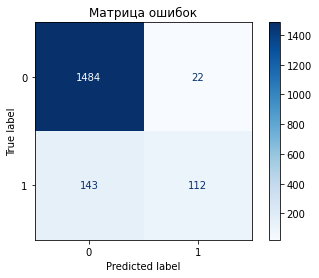

In [ ]:
y_pred_catboost = best_model_catboost.predict(x_test)
cm = confusion_matrix(y_test, y_pred_catboost)
plot_confusion_matrix(best_model_catboost, x_test, y_test, cmap=plt.cm.Blues)
plt.title('Матрица ошибок')
plt.show()

Исходя из этой матрицы ошибок, можно сделать следующие выводы:

* Верно предсказанных объектов класса 0: 1484
* Ложно предсказанных объектов класса 1: 22
* Ложно предсказанных объектов класса 0: 143
* Верно предсказанных объектов класса 1: 112

In [ ]:
y_pred_prob_catboost = best_model_catboost.predict_proba(x_test)
y_pred_prob_catboost = y_pred_prob_catboost[:, 1]

auc_roc_catboost = roc_auc_score(y_test, y_pred_prob_catboost)
print("AUC-ROC модели CatBoost на тестовой выборке: {:.4f}".format(auc_roc_catboost))

AUC-ROC модели CatBoost на тестовой выборке: 0.9023


In [ ]:
y_pred_catboost = best_model_catboost.predict(x_test)

accuracy_catboost = accuracy_score(y_test, y_pred_catboost)
print("Точность модели CatBoost на тестовой выборке: {:.4f}".format(accuracy_catboost))

Точность модели CatBoost на тестовой выборке: 0.9063


* AUC-ROC модели CatBoost на тестовой выборке: 0.90 > 0.85 что соответствует поставленной задаче.
* Точность модели CatBoost на тестовой выборке: 0.90

Эти данные подтверждают хорошую производительность модели CatBoost и ее способность точно предсказывать классы на новых данных.

Анализ важности признаков.

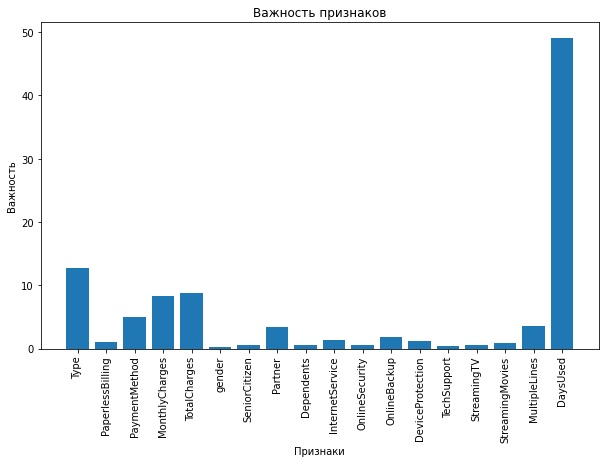

In [ ]:
feature_names = list(x_train.columns)
importances = best_model_catboost.named_steps['catboost'].feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances)
plt.xticks(range(len(importances)), feature_names, rotation='vertical')
plt.xlabel('Признаки')
plt.ylabel('Важность')
plt.title('Важность признаков')
plt.show()

Анализ важности признаков показал, что на прогноз очень сильно влияет Количество дней что клиент пользовался услугами компании, и практически не влияет gender. Всё это мы видели на тепловой карте корреляции Cramers V

**Проверим модель на адекватность**

In [ ]:
model_dummy = DummyClassifier(strategy='uniform', random_state=RANDOM_STATE)
model_dummy.fit(x_train, y_train)
y_pred_dummy = model_dummy.predict(x_test)
auc_roc_dummy = roc_auc_score(y_test, y_pred_dummy)
print("AUC-ROC модели Dummy на тестовой выборке: {:.4f}".format(auc_roc_dummy))

AUC-ROC модели Dummy на тестовой выборке: 0.5038


* AUC-ROC модели CatBoost на тестовой выборке: 0.90
* AUC-ROC модели Dummy на тестовой выборке: 0.50
Исходя из этого делаем вывод, что модель CatBoost является адекватной для задачи классификации и демонстрирует значительно лучшие результаты, чем константная модель Dummy.

**Вывод**
* AUC-ROC значение 0.90 указывает на высокую производительность модели в предсказании оттока клиентов.

* Модель верно предсказала 1484 объекта класса 0 и 112 объектов класса 1.

* Модель также совершила ошибки в предсказаниях. Было ложно предсказано 143 объекта класса 0 и 22 объекта класса 1.

Исходя из этих результатов, команда оператора связи может использовать данную модель для прогнозирования оттока клиентов. Она способна выявлять клиентов, которые планируют уйти, и предлагать им промокоды и специальные условия в попытке удержания.

# Отчёт о проделанной работе.

Дано было задание спрогнозировать отток клиентов компании 'Ниединогоразрыва.ком', для того чтобы компания могла подстраховать себя и в случае если клиент планирует уйти предложить ему скидки и промокоды.

**1. Подготовили данные**

На вход мы получили 4 датасета:
- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Содержащие информацию о 7042 клиентах компании "Ниединогоразрыва.ком". После анализа датасетов я выявила, что не все клиенты пользуются телефонией или же интернетом. Услугами интернета пользуется 5517 абонентов, а телефонией 6361 абонент. Так же при анализе я заметила что в каждом датасете имеется столбец customerID представляющий собой идентификатор абонента. Ещё обратила внимание на то, что у большей части абонентов низкие траты на услуги.

**2. Провела исследовательский анализ данных**.

Прежде чем приступить к исследованию, я объеденила 4 таблицы установив индексом колонку customerID. Благодаря столбцам "дата начала пользования услугами" и "дата окончания пользования услугами", посредством вычитания одного из другого я смогла получить новый признак "Количество дней пользования услугой". После объеденения таблиц у клиентов что не пользовались телефонией или интернетом образовались пропуски, что я удачно заполнила значением "No".

Построив гистограммы целевого признака с признаками выяснила что:
* Больше всего отказываются от услуг клиенты которые платят раз в год или в два года, чем те кто платит месяц в месяц.
* Меньше всего отказываются от услуг клиенты которые пользуется способом оплаты Mailed check
* Пол совершенно не влияет на отток
* Те кто не имеет партёра меньше отказываются от услуг оператора
* Те кто не имеет техподдержку уходят в 2 раза чаще, чем те кто имеет

* Клиенты уходят как и с низким, так и высоким ежемесячным платежём. Возможно кто-то отказывается от услуг телефонии, а для кого-то ежемесячный платёж слишком высок, в то время как со средним платежём люди уходят значительно меньше.
* Если посмотреть на платежи за всё время пользование услугами, то чаще уходят те у кого платёж не привысил 5000 у.е. те у кого общая сумма выше уходят реже. Возможно сказывается время пользования услугами.
* С продолжительностью пользования услугами клиенты кто пользуются услугами давно, гораздо реже отказываются от услуг оператора.

В столбце UserDay имеется сильная положительная корреляция, что говорит о том что срок пользования услугами компании влияет на отток клиентов, а вот пол абонента совершенно не влияет. Так же мы видим что сумма ежемесячного платежа коррелирует с типом подключения интернета (оптоволокно, кабель и т.п.), что вполне ожидаемо.

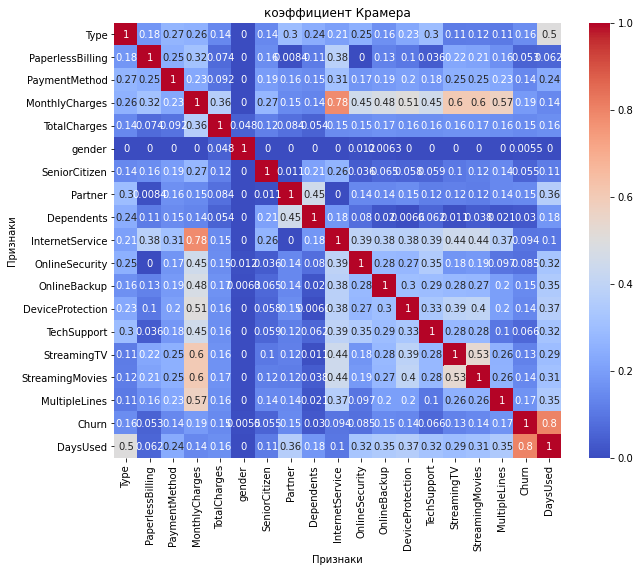

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', xticklabels=cols, yticklabels=cols)
plt.xlabel('Признаки')
plt.ylabel('Признаки')
plt.title('коэффициент Крамера')
plt.show()

Проверка на дисбаланс показала что целевой признак имеет достаточно сильный дисбаланс. Но т.к. метрика не чувствительна к выбросам, я ничего не стала с этим делать.

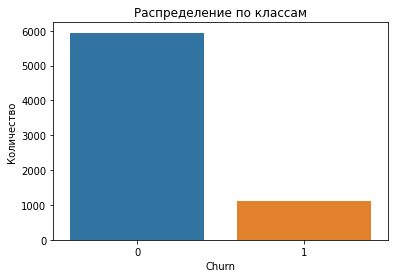

In [ ]:
sns.countplot(x='Churn', data=df)
plt.xlabel('Churn')
plt.ylabel('Количество')
plt.title('Распределение по классам')
plt.show()

**3.Подготовка данных к ML**
В этом пункте я разбила данные на выборки test и train, указав RANDOM_STATE = 220523 и test_size=0.25
Получившиеся размеры выборок:
- Тренировочная выборка: (5282, 18)
- Таргет тренировочной выборки: (5282,)
- Тестовая выборка: (1761, 18)
- Таргет тестовой выборки: (1761,)

In [ ]:
print("Лучшие параметры lgbm:", best_params_lgbm )

Лучшие параметры lgbm: {'lgbm__learning_rate': 0.01, 'lgbm__max_depth': 4, 'lgbm__n_estimators': 200}


In [ ]:
print("Лучшие параметры catboost:", best_params_catboost)

Лучшие параметры catboost: {'catboost__iterations': 200, 'catboost__learning_rate': 0.1, 'catboost__max_depth': 5}


In [ ]:
display(data_model)

,Модель,AUC-ROC,accuracy
0,LightGBM,0.699987,0.839833
1,CatBoost,0.867927,0.903635


**4.Модель**
Я провела кодирование категориальных признаков с помощью OneHotEncoder.
Использовала две модели: LGBMClassifier и CatBoostClassifier.

* Для модели LGBMClassifier был выполнен подбор оптимальных гиперпараметров с использованием GridSearchCV. Были протестированы различные значения для параметров 'n_estimators', 'max_depth' и 'learning_rate'. Лучшая модель была выбрана на основе метрики AUC-ROC и получила следующие параметры: 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.1. Лучшая метрика AUC-ROC для данной модели составила 0.70, а accuracy 0.83.

* Для модели CatBoostClassifier также был выполнен подбор оптимальных гиперпараметров с помощью GridSearchCV. Были протестированы различные значения для параметров 'iterations', 'max_depth' и 'learning_rate'. Лучшая модель была выбрана на основе метрики AUC-ROC и получила следующие параметры: 'iterations': 200, 'max_depth': 5, 'learning_rate': 0.1. Лучшая метрика AUC-ROC для данной модели составила 0.86, а accuracy 0.90.

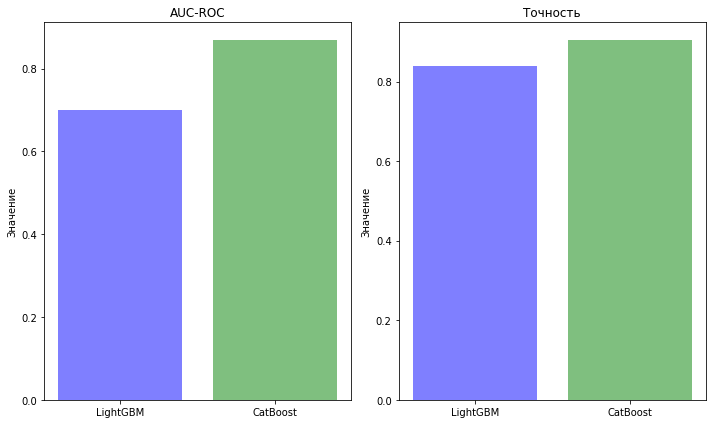

In [ ]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.bar(models, auc_roc, alpha=0.5, color=['blue', 'green', 'red'])
plt.title('AUC-ROC')
plt.ylabel('Значение')

plt.subplot(1, 2, 2)
plt.bar(models, accuracy, alpha=0.5, color=['blue', 'green', 'red'])
plt.title('Точность')
plt.ylabel('Значение')

plt.tight_layout()
plt.show()

**Проверить модель на адекватность и соответствию метрики AUC-ROC**


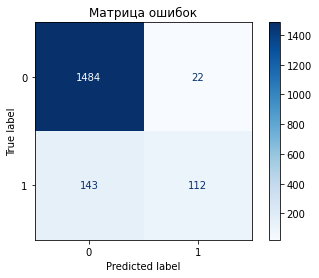

In [ ]:
plot_confusion_matrix(best_model_catboost, x_test, y_test, cmap=plt.cm.Blues)
plt.title('Матрица ошибок')
plt.show()

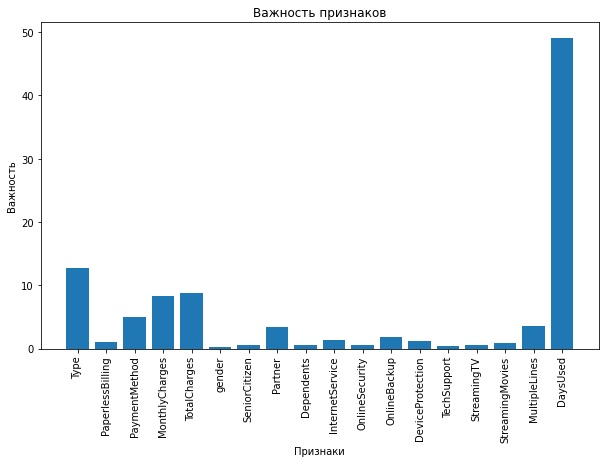

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances)
plt.xticks(range(len(importances)), feature_names, rotation='vertical')
plt.xlabel('Признаки')
plt.ylabel('Важность')
plt.title('Важность признаков')
plt.show()

В результате проведенного анализа итоговой модели можно сделать следующие выводы:

* Модель CatBoostClassifier показала более высокую метрику AUC-ROC - 0.90, accyracy - 0.90
* Важность признаков была оценена с помощью анализа feature_importances. Признаки 'TotalCharges', 'MonthlyCharges', 'DaysUsed' и 'Type' оказались наиболее значимыми для обеих моделей.

Матрица ошибок показала:
* Верно предсказанных объектов класса 0: 1484
* Ложно предсказанных объектов класса 1: 22
* Ложно предсказанных объектов класса 0: 143
* Верно предсказанных объектов класса 1: 112

Сравнение с константной моделью показало что CatBoost показал значительно лучший результат по сравнению с Dummy-моделью. ROC-AUC для CatBoost 0.86 гораздо выше, чем для Dummy-модели 0.50. Это говорит о том, что CatBoost значительно лучше предсказывает целевой признак.

Так-же модель выполняет условие заказчика показывая метрику AUC-ROC 0.90, ято больше чем 0.85.